In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob

In [2]:
def extract_pwat_data(filename_list,data_name):

    filenum = 0
    for file in filename_list:
        data = xr.open_dataset(file)
        extracted = np.asarray(data[data_name]).reshape(-1,103*120).T
        
#         if extracted.shape[-1] == 1463:
#             extracted = np.concatenate((extracted[:,:59*4],extracted[:,60*4:]),axis=-1)
        extracted = extracted[:,::4]
        print(extracted.shape)

        if filenum == 0:
            data_matrix = extracted
            filenum+=1
        else:
            data_matrix = np.concatenate((data_matrix,extracted),axis=-1)
            
    nanmean = np.nanmean(data_matrix)
    data_matrix = np.nan_to_num(data_matrix,nan=nanmean)
            
    return data_matrix


def extract_z500_data(filename_list,data_name):

    filenum = 0
    for file in filename_list:
        data = xr.open_dataset(file)
        extracted = np.asarray(data[data_name]).reshape(-1,103*120).T
        
        if extracted.shape[-1] == 366:
            extracted = np.concatenate((extracted[:,:58],extracted[:,59:]),axis=-1)
        print(extracted.shape)

        if filenum == 0:
            data_matrix = extracted
            filenum+=1
        else:
            data_matrix = np.concatenate((data_matrix,extracted),axis=-1)
            
    nanmean = np.nanmean(data_matrix)
    data_matrix = np.nan_to_num(data_matrix,nan=nanmean)
            
    return data_matrix

In [3]:
year_list = np.arange(1995,1999,step=1)
pwat_filename_list = []
z500_filename_list = []

for year in year_list:
    pwat_filename_list.append('./IWV/IWV_'+str(year)+'.nc.d')
    z500_filename_list.append('./z500/Z500_'+str(year)+'.nc')
    
pwat_data_train = extract_pwat_data(pwat_filename_list,'IWV')
z500_data_train = extract_z500_data(z500_filename_list,'z500')

(12360, 365)
(12360, 365)
(12360, 365)
(12360, 365)
(12360, 365)
(12360, 365)
(12360, 365)
(12360, 365)


In [5]:
pwat_data_test = extract_pwat_data(['./IWV/IWV_1999.nc.d'],'IWV')
z500_data_test = extract_z500_data(['./z500/Z500_1999.nc'],'z500')

(12360, 365)
(12360, 365)


In [6]:
# Split train and test
np.save('PWAT_Train_Snapshots.npy',pwat_data_train)
np.save('PWAT_Test_Snapshots.npy',pwat_data_test)

np.save('Z500_Train_Snapshots.npy',z500_data_train)
np.save('Z500_Test_Snapshots.npy',z500_data_test)

In [7]:
print(training_fluc.shape)
print(testing_fluc.shape)
print(data_mean.shape)

(12360, 2192)
(12360, 3651)
(12360,)


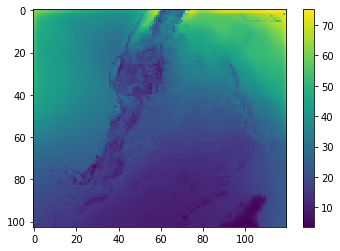

In [8]:
plt.figure()
plt.imshow(data_mean.reshape(103,120))
plt.colorbar()
plt.show()

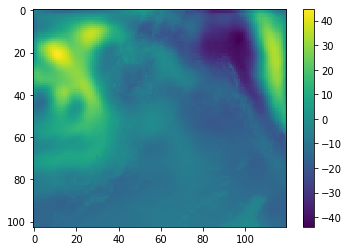

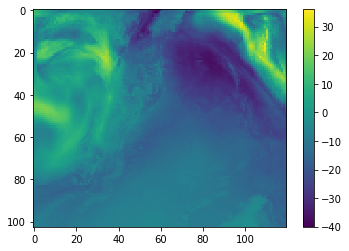

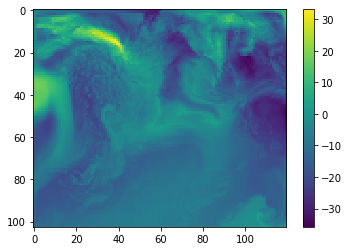

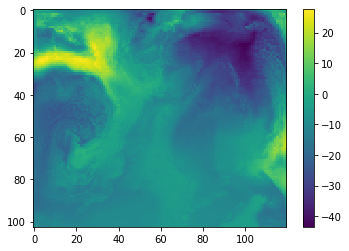

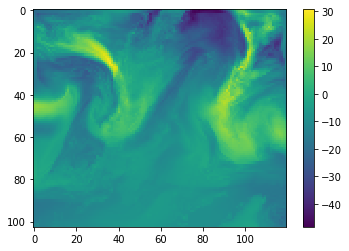

In [9]:
for i in range(0,100,20):
    plt.figure()
    plt.imshow(training_fluc.reshape(103,120,-1)[:,:,i])
    plt.colorbar()
    plt.show()

In [10]:
print(training_fluc.shape)
print(testing_fluc.shape)

(12360, 2192)
(12360, 3651)


### POD computation

In [16]:
u, s, _ = np.linalg.svd(training_fluc,full_matrices=False)

In [17]:
np.save('POD_Modes.npy',u)
np.save('Singular_Values.npy',s)

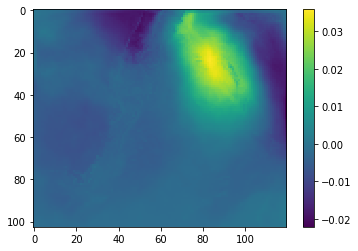

In [18]:
plt.figure()
plt.imshow(u[:,1].reshape(103,120))
plt.colorbar()
plt.show()

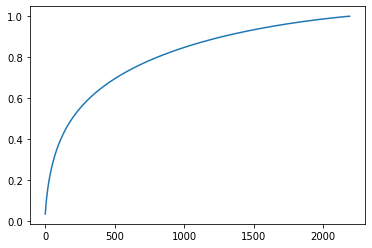

In [19]:
plt.figure()
plt.plot(np.cumsum(s)/np.sum(s))
plt.show()

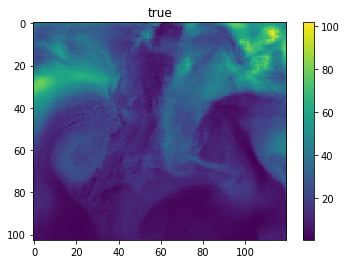

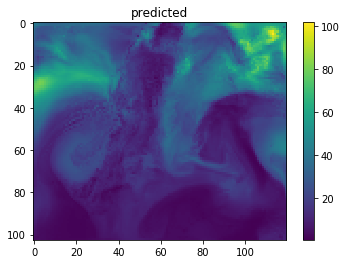

In [20]:
training_coeffs = np.matmul(u.T,training_fluc)
testing_coeffs = np.matmul(u.T,testing_fluc)

# Check reconstruction accuracy
snapshot_num = 100
true = pwat_data_train[:,snapshot_num].reshape(103,120)

plt.figure()
plt.imshow(true)
plt.colorbar()
plt.title('true')
plt.show()


# Check reconstruction accuracy
pred = data_mean.reshape(103,120) + np.matmul(u,training_coeffs)[:,snapshot_num].reshape(103,120)

plt.figure()
plt.imshow(pred)
plt.colorbar()
plt.title('predicted')
plt.show()

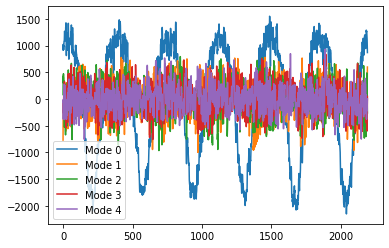

In [21]:
plt.figure()
plt.plot(training_coeffs[0,:],label='Mode 0')
plt.plot(training_coeffs[1,:],label='Mode 1')
plt.plot(training_coeffs[2,:],label='Mode 2')
plt.plot(training_coeffs[3,:],label='Mode 3')
plt.plot(training_coeffs[4,:],label='Mode 4')
plt.legend()
plt.show()

In [22]:
np.save('Training_Coefficients.npy',training_coeffs)
np.save('Testing_Coefficients.npy',testing_coeffs)

### Do data cleaning using empirical mode decomposition

In [ ]:
from PyEMD import EMD
detail_int = 5
max_modes = 100

smooth_training_coeffs = training_coeffs[:max_modes]
smooth_testing_coeffs = testing_coeffs[:max_modes]

for i in range(2,smooth_training_coeffs.shape[0]):
    emd = EMD()
    IMFs = emd.emd(smooth_training_coeffs[i])
    
    plt.figure()
    plt.plot(np.sum(IMFs[detail_int:],axis=0),linewidth=4)
    plt.plot(smooth_training_coeffs[i,:],alpha=0.2)
    plt.show()
    
    smooth_training_coeffs[i] = np.sum(IMFs[detail_int:],axis=0)
    
    emd = EMD()
    IMFs = emd.emd(smooth_testing_coeffs[i])
    
    plt.figure()
    plt.plot(np.sum(IMFs[detail_int:],axis=0),linewidth=4)
    plt.plot(smooth_testing_coeffs[i,:],alpha=0.2)
    plt.show()
    
    smooth_testing_coeffs[i] = np.sum(IMFs[detail_int:],axis=0)
    
    

In [ ]:
np.save('EMD_Training_Coefficients.npy',smooth_training_coeffs)
np.save('EMD_Testing_Coefficients.npy',smooth_testing_coeffs)